# Lanusita District Dynamics Analysis: Understanding Shop Types Distribution and Busy Hours!

## Introduction

Lanusita District is a small urban area located within the city of Lanús, part of the Greater Buenos Aires metropolitan area in Argentina. In recent years, Lanusita has experienced significant development, particularly in the gastronomic sector, with substantial investments contributing to its growth and popularity as a commercial and entertainment hub.

In this analysis, I aim to understand and visualize the overall commercial dynamics of the area by examining the types of shops and their performance. 

The greatest challenge in this project is obtaining data about all the shops in the area. The scope of analysis is limited by the data we can access, and the goal is to automate this process as much as possible, hoping in the future to expand this type of analysis to a larger scale and apply it to any given location.

This Jupyter Notebook is mainly a walkthrough of how the whole ETL process was, the actual processing was done on Spyder.

This are the types of information that I was interested in obtaining:
- **Shop Type Trends**: Data on which types of shops and businesses are most popular.
- **Consumer Traffic**: Analysis of peak hours and days of the week for consumer traffic, which can help in optimizing business opening hours and marketing efforts.

## Defining Lanusita District borders 

In [1]:
import folium

lanusita = folium.Map(location=[-34.703785, -58.393213], zoom_start=16)
northeast = (-34.700190, -58.391741)
southwest = (-34.708226, -58.394751)

bounds = [northeast, southwest]

# Add rectangle to the map
folium.Rectangle(bounds=bounds, color='blue', fill=True, fill_color='blue', fill_opacity=0.2).add_to(lanusita)

lanusita

## Shop Type Trends - Google Maps Scrapping

I am going to analyze trends using data from Google's [Places API](https://developers.google.com/maps/documentation/places/web-service/overview), which gives us type of bussiness, location, opening hours, ratings and more.

### Using Google's Places API

Google Places API has a search-type endpoint based on closeness to a center and radius, named [Places Nearby](https://developers.google.com/maps/documentation/places/web-service/search-nearby), where is also possible to filter by place type. For each request there is a maximum of 20 places to be returned, in case there's more than 20, next page token can be requested, meaning more places with the same parameters can be returned, this can be done three times, meaning there's still a maximum of 60 obtainable places per request. 
To get around this limitation and maximize the places scrapped we are going to implement different methods.


 1) **Gridded points:** 
Rather than covering the district with a big enough circle, we can define a circle in the center of each block in the district.
2) **Type search:**
Perform searches using different types of places, varying the type may give additional results.

### Generate  gridded points

In [2]:
# Function to generate equidistant points in a rectangle (7x2)
def generate_points(northeast, southwest, num_rows, num_columns):
    lat_diff = northeast[0] - southwest[0]
    lon_diff = northeast[1] - southwest[1]
    
    points = []
    
    for i in range(num_rows):
        for j in range(num_columns):  # width
            lat = southwest[0] + i * lat_diff / (num_rows - 1)
            lon = southwest[1] + j * lon_diff
            points.append((lat, lon))
    
    return points


# New smaller rectangle
northeast = (-34.700816, -58.392594)
southwest = (-34.707390, -58.393968)

points_7x2 = generate_points(northeast, southwest, 7, 2)

# Create a map centered on the rectangle
mapa = folium.Map(location=[(northeast[0] + southwest[0]) / 2, (northeast[1] + southwest[1]) / 2], zoom_start=16)

# Function to add points and circles to the map
def add_point_and_circles(mapa, points, radius, point_col, circle_col):
    for lat, lon in points:
        # Add point
        folium.Marker(location=[lat, lon], icon=folium.Icon(color=point_col)).add_to(mapa)
        # Add circle
        folium.Circle(
            location=[lat, lon],
            radius=radius,
            color=circle_col,
            fill=True,
            fill_color=circle_col,
            fill_opacity=0.5
        ).add_to(mapa)

# Add points (7x2) and their circles
add_point_and_circles(mapa, points_7x2, 110, 'red', 'blue')

mapa

### Initialize place types

In [3]:
# Get all relevant place types:
types_list = []
types_list.append(None)

with open('data/place_types.txt', 'r') as file:
    for line in file:
        p_type = line.strip()
        types_list.append(p_type)
        
print('Number of different place types: ' + str(len(types_list)))

Number of different place types: 87


### Get places from Places Nearby
First I define a "get_all_places" function that has location, radius, place type as parameters and automatically detects if there is a next page token.

In [ ]:
import googlemaps
from GoogleAPIKey import key
import time

API_KEY = key()

#Client
gmaps = googlemaps.Client(key = API_KEY)

# Get all places in the area (there is a 60 places limit, even using next page tokens)
def get_all_places(location, radius, type=None):
    places = []
    next_page_token = None

    while True:
        # Run Places Nearby
        if next_page_token:
            response = gmaps.places_nearby(page_token = next_page_token)
        else:
            response = gmaps.places_nearby(location=location, radius=radius, type=place_type)
        
        places.extend(response.get('results', []))
        
        # Verify if there is a next page token
        next_page_token = response.get('next_page_token', None)
        
        if not next_page_token:
            print(type)
            break
        
        # Wait a little before next request
        time.sleep(3)
    
    for place in places:
        place['search_parameters'] = {
            'radius': radius,
            'type': place_type
        }

    return places

Run "get_all_places" for each type and each point in the grid.

In [ ]:
all_places = []

for place_type in types_list:
    for point in points_7x2:
        all_places += get_all_places(point, 110, type = place_type)

### Export to .xlsx file

In [4]:
import pandas as pd

In [ ]:
df = pd.DataFrame(all_places)

df.to_excel(r'data/all_results.xlsx', index=False)

### Drop duplicates

In [ ]:
df = pd.read_excel(r'data/all_results.xlsx')

df_clean = df.drop_duplicates(subset='place_id')

df_clean.to_excel(r'data/all_results_nd.xlsx', index=False)

In [5]:
df_clean = pd.read_excel(r'data/all_results_nd.xlsx')
df_clean.head()

,geometry,icon,icon_background_color,icon_mask_base_uri,name,photos,place_id,reference,scope,types,vicinity,search_parameters,business_status,opening_hours,plus_code,rating,user_ratings_total,permanently_closed,price_level
0,"{'location': {'lat': -34.7067455, 'lng': -58.3...",https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Lanús,"[{'height': 1080, 'html_attributions': ['<a hr...",ChIJt8_zlCHNvJURYFJXHZBKBYw,ChIJt8_zlCHNvJURYFJXHZBKBYw,GOOGLE,"['locality', 'political']",Lanús,"{'radius': 110, 'type': None}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"{'location': {'lat': -34.7076616, 'lng': -58.3...",https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,RDA - Gynecological Institute Buenos Aires,"[{'height': 2560, 'html_attributions': ['<a hr...",ChIJz15_eCLNvJURLdcnsgJfwWU,ChIJz15_eCLNvJURLdcnsgJfwWU,GOOGLE,"['point_of_interest', 'health', 'establishment']",Doctor Arturo Melo 2989,"{'radius': 110, 'type': None}",OPERATIONAL,{'open_now': False},"{'compound_code': '7JR4+W5 Lanús, Buenos Aires...",3.3,164.0,NaN,NaN
2,"{'location': {'lat': -34.7076052, 'lng': -58.3...",https://maps.gstatic.com/mapfiles/place_api/ic...,#4B96F3,https://maps.gstatic.com/mapfiles/place_api/ic...,Chrystiuk Indumentaria,NaN,ChIJxUbkdyLNvJURFslEjDcCQ8E,ChIJxUbkdyLNvJURFslEjDcCQ8E,GOOGLE,"['clothing_store', 'store', 'point_of_interest...",Doctor Arturo Melo 2982,"{'radius': 110, 'type': None}",OPERATIONAL,{'open_now': False},"{'compound_code': '7JR4+X7 Lanús, Buenos Aires...",NaN,NaN,NaN,NaN
3,"{'location': {'lat': -34.707557, 'lng': -58.39...",https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Ramallo Propiedades,"[{'height': 786, 'html_attributions': ['<a hre...",ChIJ6YX4dyLNvJURV_IsJlUG0h8,ChIJ6YX4dyLNvJURV_IsJlUG0h8,GOOGLE,"['real_estate_agency', 'point_of_interest', 'e...",Doctor Arturo Melo 2990,"{'radius': 110, 'type': None}",OPERATIONAL,{'open_now': False},"{'compound_code': '7JR4+X8 Lanús, Buenos Aires...",4.6,9.0,NaN,NaN
4,"{'location': {'lat': -34.707631, 'lng': -58.39...",https://maps.gstatic.com/mapfiles/place_api/ic...,#4B96F3,https://maps.gstatic.com/mapfiles/place_api/ic...,Intima,NaN,ChIJc0zreSLNvJURgsZScrcu5CE,ChIJc0zreSLNvJURgsZScrcu5CE,GOOGLE,"['clothing_store', 'store', 'point_of_interest...","Doctor Arturo Melo 990, Gran Buenos Aires","{'radius': 110, 'type': None}",OPERATIONAL,{'open_now': False},"{'compound_code': '7JR4+W8 Lanús, Buenos Aires...",NaN,NaN,NaN,NaN


### Visualize locations scrapped

In [6]:
import json
import folium
from folium.plugins import MarkerCluster

df_clean['geometry'] = df_clean['geometry'].apply(lambda x: json.loads(x.replace("'", '"')))
df_clean['location'] = None

mapa = folium.Map(location=[-34.703785, -58.393213], zoom_start=16)
    
for index, row in df_clean.iterrows():
    lat = row['geometry']['location']['lat']
    lng = row['geometry']['location']['lng']
    name = row['name']
    df_clean.at[index, 'location'] = (lat, lng)
    folium.CircleMarker(location=[lat, lng], radius=3, color='blue', fill=True, 
                        fill_color='blue', fill_opacity=0.5, tooltip=name).add_to(mapa)

mapa


### Get details from Places Details

In [8]:
df = pd.read_excel(r'data/all_results_nd.xlsx')

wanted_fields = []

# Initialize wanted details for each place and add new columns
with open(r'data/fields.txt', 'r') as file:
    for line in file:
        word = line.strip()
        wanted_fields.append(word)
        if word not in df.columns:
            df[word] = None

wanted_fields

['curbside_pickup',
 'delivery',
 'dine_in',
 'editorial_summary',
 'price_level',
 'rating',
 'reservable',
 'serves_beer',
 'serves_breakfast',
 'serves_brunch',
 'serves_dinner',
 'serves_lunch',
 'serves_vegetarian_food',
 'serves_wine',
 'takeout',
 'user_ratings_total',
 'current_opening_hours',
 'formatted_phone_number',
 'opening_hours',
 'secondary_opening_hours',
 'website']

In [ ]:
for index, row in df.iterrows():
    p_id = row['place_id']
    place_details = gmaps.place(place_id=p_id, fields=wanted_fields)
    result = place_details.get('result', None)
    
    if result:
        for key, val in result.items():
            df.at[index, key] = val

### Clean location data

In [ ]:
import json
import pandas as pd
import numpy as np

# Get lat and lng as columns
df['geometry'] = df_clean['geometry'].apply(lambda x: json.loads(x.replace("'", '"')))

df['lat'] = df['geometry'].apply(lambda x: x['location']['lat'])
df['lng'] = df['geometry'].apply(lambda x: x['location']['lng'])

# New column to aid visualization for repeated coordinates
adj = 0.00002
df['lat_adjusted'] = df['lat'] + np.where(df.duplicated(subset=['lat', 'lng'], keep='first'), -adj, 0)
df['lng_adjusted'] = df['lng'] + np.where(df.duplicated(subset=['lat', 'lng'], keep='first'), adj, 0)

df.to_excel(r'data/all_results_nd_details.xlsx', index=False)

### New relationship table between place_id and type

In [ ]:
df = pd.read_excel(r'data/all_results_nd_details.xlsx')

df_types = df[df['business_status'] != 'CLOSED_TEMPORARILY'][['place_id','types']]

df_types.to_csv(r'data/place_id_types.csv', index=False)

In [9]:
df_types = pd.read_csv(r'data/place_id_types.csv')
df_types.head()

,place_id,type
0,ChIJt8_zlCHNvJURYFJXHZBKBYw,"['locality', 'political']"
1,ChIJz15_eCLNvJURLdcnsgJfwWU,"['point_of_interest', 'health', 'establishment']"
2,ChIJxUbkdyLNvJURFslEjDcCQ8E,"['clothing_store', 'store', 'point_of_interest..."
3,ChIJ6YX4dyLNvJURV_IsJlUG0h8,"['real_estate_agency', 'point_of_interest', 'e..."
4,ChIJc0zreSLNvJURgsZScrcu5CE,"['clothing_store', 'store', 'point_of_interest..."


### Extract opening hours as new table

In [ ]:
import pandas as pd

df = pd.read_excel(r'data/all_results_nd_details.xlsx')
opening_hours = df[~df['opening_hours'].isna()][['place_id','opening_hours']]


def process_opening_hours(places_hours):
    
    hours_in_periods = []
    
    def convert_end(day ,time_str):
        hour = int(time_str[:2])
        mins = int(time_str[2:])
        if hour == 0 and mins == 0:
            day = (day - 1) % 7
            hour = 23
        elif mins == 0:
            hour -= 1
        return day, hour

    def convert_start(time_str):
        hour = int(time_str[:2])
        return hour

    def calculate_hours(place_id, start_day, start_hour, end_day, end_hour):
        hours = []
        current_day = start_day
        current_hour = start_hour
        
        while True:
            hours.append({'place_id': place_id, 'day': current_day, 'hour': current_hour})
            current_hour += 1
            if current_hour == 24:
                current_hour = 0
                current_day = (current_day + 1) % 7
            
            if current_day == end_day and current_hour == end_hour:
                hours.append({'place_id': place_id, 'day': current_day, 'hour': current_hour})
                break

        return hours
    
    for index, row in places_hours.iterrows():
        #print(index)
        place_id = row['place_id']
        #print(place_id)
        data = row['opening_hours']
        # Make JSON readable
        data = data.replace("'", '"').replace('True','true').replace('False','false')
        # Load JSON
        data = json.loads(data)
        
        periods = data['periods']
        
        for p in periods:
            start_day = p['open']['day']
            start_hour = convert_start(p['open']['time'])
            end_day, end_hour = convert_end(p.get('close', {}).get('day', 6), p.get('close', {}).get('time', '2359'))
            
            hours_in_periods.extend(calculate_hours(place_id, start_day, start_hour, end_day, end_hour))
    
    df = pd.DataFrame(hours_in_periods)
    
    df.to_csv(r'data/available_open_times.csv', index=False)
        
process_opening_hours(opening_hours)

In [10]:
df_open_hours = pd.read_csv(r'data/available_open_times.csv')
df_open_hours.head()

,place_id,day,hour
0,ChIJz15_eCLNvJURLdcnsgJfwWU,1,9
1,ChIJz15_eCLNvJURLdcnsgJfwWU,1,10
2,ChIJz15_eCLNvJURLdcnsgJfwWU,1,11
3,ChIJz15_eCLNvJURLdcnsgJfwWU,1,12
4,ChIJz15_eCLNvJURLdcnsgJfwWU,1,13


## Consumer Traffic - Popular Times Scraping with Beautiful Soup
To analyze consumer traffic, I decided to use Google Map's [Popular Times](https://support.google.com/business/answer/6263531?hl=en#:~:text=Popular%20times%20graph%3A%20This%20graph,the%20business%20for%20the%20week.) feature. This feature provides real-time attendance data and historical averages, giving an idea of how many people are at a location at a given time or, on average, over a specific period.

However, this information is not available through any Google API, so I needed to find an alternative approach.

The solution I came up with is to scrape the data (if available) by using a web driver to visit each place, generating the google map link using their 'place_id'. After that, I parse the HTML content to extract the required information using Beautiful Soup.

### Defining functions

In [ ]:
import re
from bs4 import BeautifulSoup
import pandas as pd

# Pattern to match percentage, hour, and period
pattern = re.compile(r'(\d+)%.*?(\d+)\s*(a\.m\.|p\.m\.)')
dias = ['domingo', 'lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado']

rows = []

                
def process_html_for_place_id(place_id, C7xf8b_html):
    global rows  # To update the global DataFrame

    # Parse the HTML content
    soup = BeautifulSoup(C7xf8b_html, 'html.parser')
    
    main_div = soup.find('div', class_='C7xf8b')

    if main_div:
        print(f"Processing {place_id}...")
        d = 0
        # Iter for classes inside "C7xf8b"
        for div_day in main_div.find_all(recursive=False):  # rec = False --> Just get direct sub divs
            print(d)
            
            print('-'*50)
            elements_with_aria_label = div_day.find_all(attrs={'aria-label': True})
            for element in elements_with_aria_label:
                aria_label = element['aria-label']
                match = re.search(pattern, aria_label)
                
                if match:
                    percentage, hour, period = match.groups()
                    # Append to the DataFrame
                    rows.append({
                        'place_id': place_id,
                        'day': d,
                        'percentage': percentage,
                        'hour': hour,
                        'period': period.replace('.','')
                    })
            d += 1

In [ ]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.options import Options
from selenium.common.exceptions import NoSuchElementException # For when class C7xf8b is not found

def process_all_places(place_ids, route):
    # Set up driver options
    edge_options = Options()
    edge_options.add_argument("--headless")  # Headless mode
    edge_options.add_argument("--disable-gpu")  # Disable GPU acceleration

    # Specify the path to the Edge WebDriver
    service = Service(r'C:\Users\LCD\Desktop\edge_driver\msedgedriver.exe')

    # Initialize the WebDriver
    driver = webdriver.Edge(service=service, options=edge_options)
    
    class_name = 'C7xf8b '
    
    for place_id in place_ids:
        # Navigate webpage
        driver.get(f'https://www.google.com/maps/search/?api=1&query=%3Caddress%3E&query_place_id={place_id}')
        print(f'https://www.google.com/maps/search/?api=1&query=%3Caddress%3E&query_place_id={place_id}')
        try:
            # Find the element by class name
            element = driver.find_element(By.CLASS_NAME, class_name)
            
            # Extract and print the entire HTML content of the element
            html_content = element.get_attribute('outerHTML')
            
            process_html_for_place_id(place_id, html_content)
        
        # Handle exception if popular time class not found
        except NoSuchElementException:
            print('exception')
            pass

    # Close the driver
    driver.quit()

    # Save DataFrame
    df_pop_times = pd.DataFrame(rows)
    df_pop_times.to_csv(route, index=False)

### Getting popular times!
I divided the task into two steps. First, because I wanted to test the functions on a samller scale to ensure everything was working as expected, second because I was courious to find out if there were places with popular times available that didnt have specified opening hours.

In [ ]:
df = pd.read_excel(r'data/all_results_nd.xlsx')

# Places that DONT have opening hours specified
df_1 = df[(df['opening_hours'].isna()) & (df['business_status'] != 'CLOSED_TEMPORARILY')].reset_index(drop=True)

place_ids = df_1['place_id']
save_dir = r'data/pop_times.csv'

process_all_places(place_ids, save_dir)

In [11]:
df_types = pd.read_csv(r'data/place_id_types.csv')
df_pop_times = pd.read_csv(r'data/pop_times.csv')['place_id']

df_intersection = pd.merge(df_types, df_pop_times, on='place_id', how='inner')
df_intersection = df_intersection.drop_duplicates()

df_intersection['type'].value_counts()

['transit_station', 'point_of_interest', 'establishment']    27
Name: type, dtype: int64

The answer was yes, but it turns out that all the places with "Popular Times" data in this case were transit stations. This data would be interesting to analyze on a larger scale. For instance, it could be used to analyze the relationship between the popular times of various businesses and their proximity to busy bus stops.

In [ ]:
# Places that have opening hours specified
df_2 = df[(~df['opening_hours'].isna()) & (df['business_status'] != 'CLOSED_TEMPORARILY')].reset_index(drop=True)

place_ids = df_2['place_id']
save_dir = r'data/pop_times2.csv'

process_all_places(place_ids, save_dir)

## Visualization and analysis
Given the interactive and dynamic capabilities of Power BI, I thought it would be the best tool to visualize and interact with the data obtained. Unfortunately, I don't have a license to publish or share the report, but the **.pbix** file is available on the project's repository. 

Here’s a static snippet of the final results.

### Shop type distribution

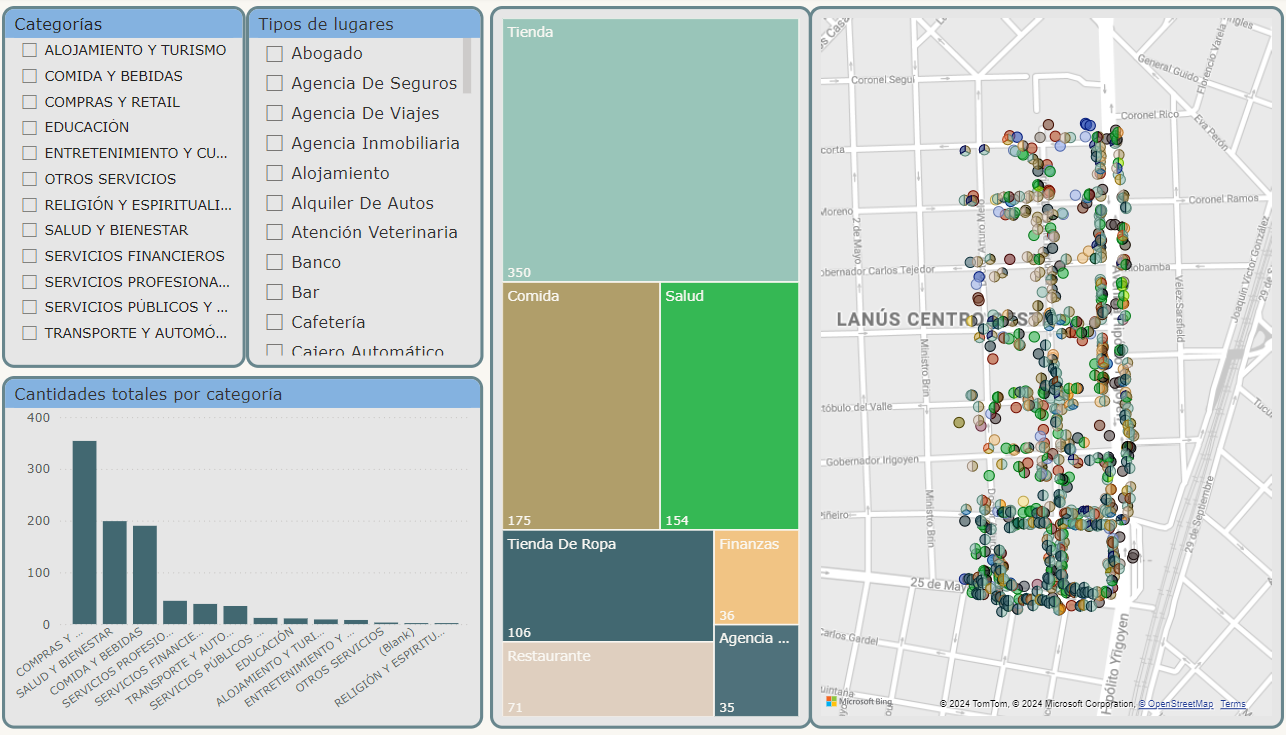

Given the large number of different types of shops, I categorized them to summarize the information more effectively. The goal of this page is to visualize and understand the most frequent types of businesses. 

Interestingly, even though the Lanusita is commonly known as a gastronomic district, general retail shops are actually the most prominent type of business in the area.

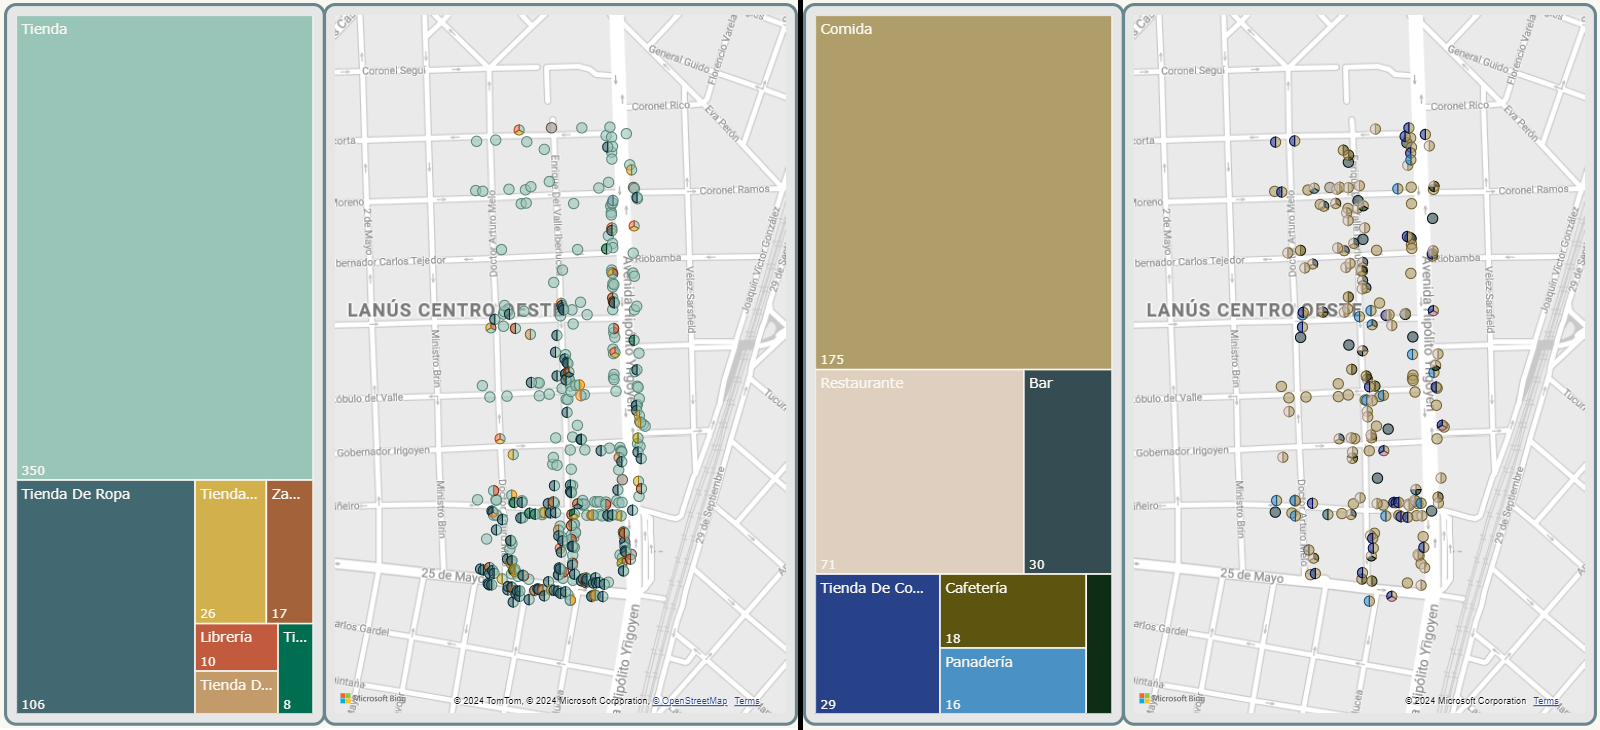

On the left the distribution of all types of retail stores, on the right the distribution of food or drink businesses.

In the Power BI report, there are more filters to explore and find the distribution of each specific type of business. This helps to identify which types of businesses may be overpopulated and where there might be opportunities to open a new business with low competition in the area.

### Popular times by day and hour


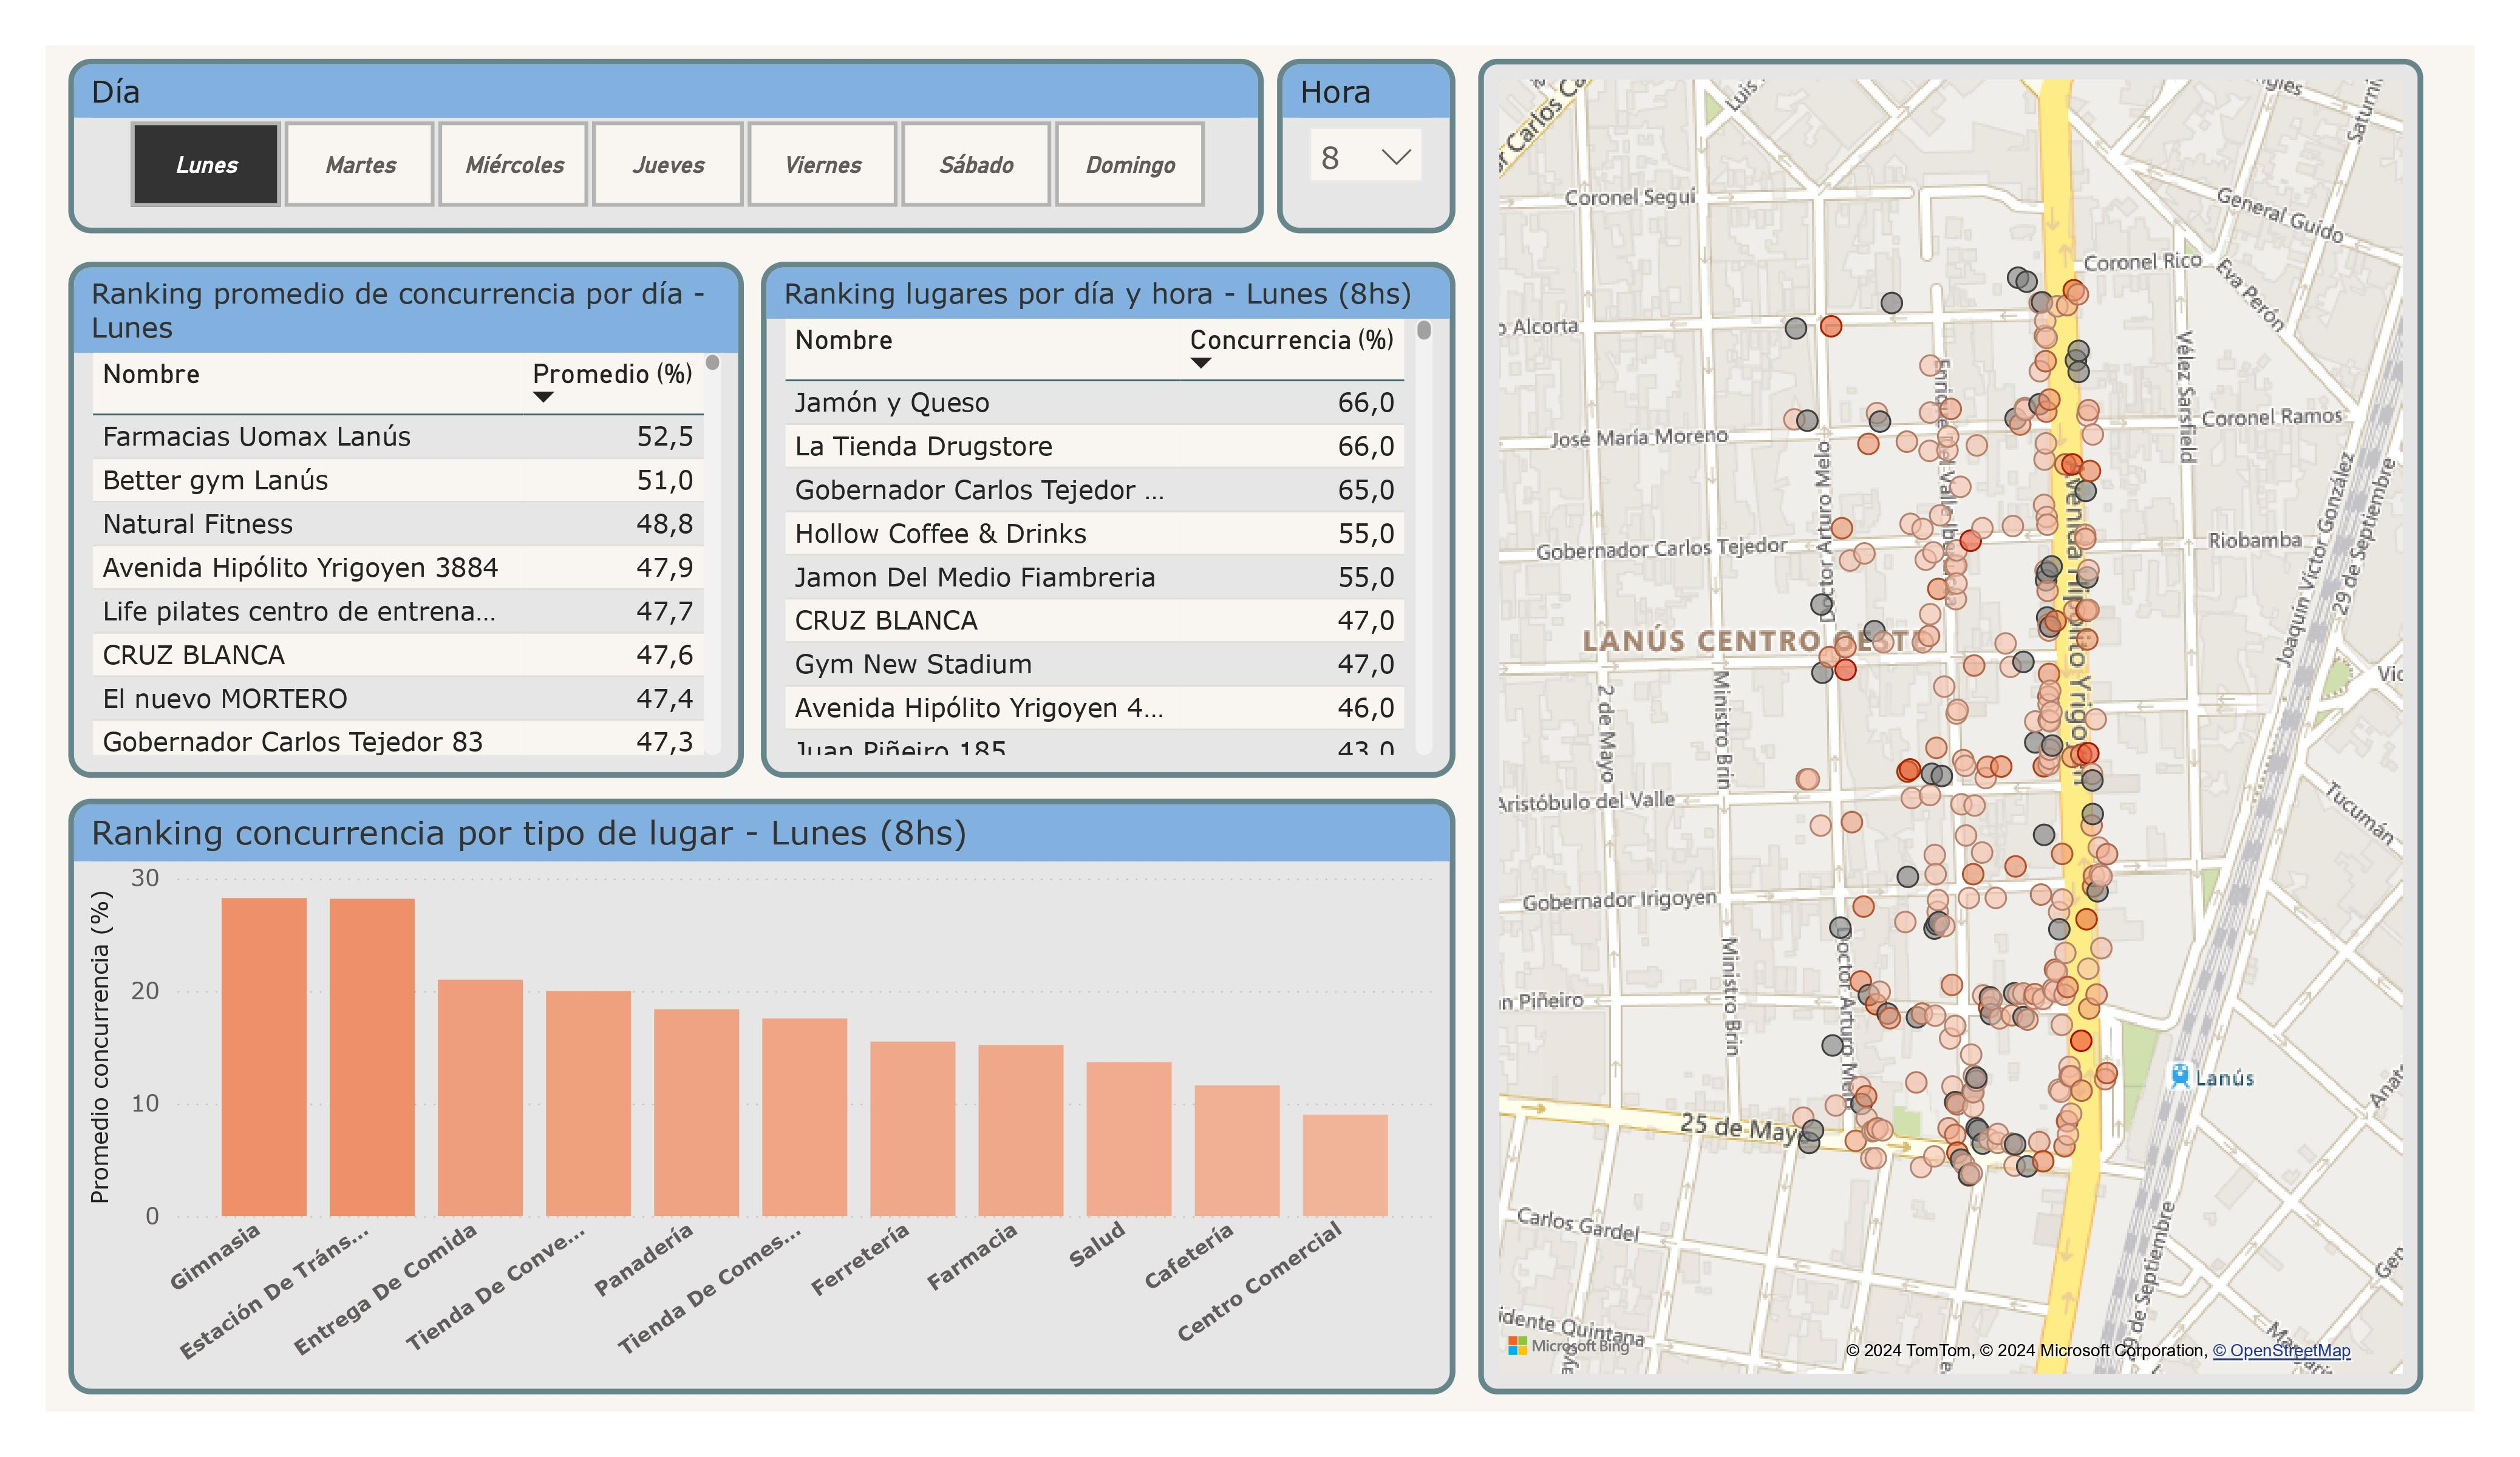

This page displays the level of attendance for each business and provides summary information about each category for both the entire day and a specific time. In this image, the specific time shown is Monday at 8 a.m., where you can see that gyms are the busiest category of business at that time.

It's important to note that the "Popular Times" data in this project is quite limited. On a larger scale, such as across the entire city of Lanús, this data could be a valuable tool for identifying areas with the highest customer density based on the time of day and type of business.